In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
def prepare_dataset(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()
	# input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  if dropnan:
    agg.dropna(inplace=True)
  return agg

In [4]:
def tt_split(df):
  df.drop(list(df)[13:], axis=1, inplace=True)
  values = df.values
  training_size = int(len(reframed)*0.80)
  train = values[:training_size, :]
  test = values[training_size:, :]
  trainX, trainy = train[:, :-1], train[:, -1]
  testX, testy = test[:, :-1], test[:, -1]
  trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
  testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
  return trainX, trainy, testX, testy

In [5]:
def loss_plot(history, title_part):
  plt.figure(figsize=(10,5))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Loss Plot for ' + title_part)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['Train', 'Validation'], loc='upper right')
  plt.show()

In [6]:
def predictions(testX, testy, scaler, title_part):
  yhat = model.predict(testX)
  testX = testX.reshape((testX.shape[0], testX.shape[2]))
  # invert scaling for forecast
  invyhat = np.concatenate((yhat, testX[:, 1:]), axis=1)
  invyhat = scaler.inverse_transform(invyhat)
  invyhat = invyhat[:,0]
  # invert scaling for actual
  testy = testy.reshape((len(testy), 1))
  invy = np.concatenate((testy, testX[:, 1:]), axis=1)
  invy = scaler.inverse_transform(invy)
  invy = invy[:,0]
  # calculate RMSE and MAE and MAPE
  mae = mean_absolute_error(invy, invyhat)
  print("The mean absolute error for " + title_part + " is " + str(mae))
  mse = mean_squared_error(invy, invyhat)
  print("The mean squared error for " + title_part + " is " + str(mse))
  rmse = mean_squared_error(invy, invyhat, squared=False)
  print("The root mean squared error for " + title_part + " is " + str(rmse))
  r2 = r2_score(invy, invyhat)
  print("The r2 score for " + title_part + " is " + str(r2))
  ar2 = 1 - (1 - r2)*((len(testX) - 1)/(len(testX) - len(testX[0]) - 1))
  print("The adjusted r2 score for " + title_part + " is " + str(ar2))
  rmsle = mean_squared_log_error(invy, invyhat, squared=False) 
  print("The root mean squared log error for " + title_part + " is " + str(rmsle))
  # plot prediction vs actual
  plt.figure(figsize=(15,5))
  plt.plot(invy,label="True Value",alpha=0.5)
  plt.plot(invyhat,label="Predicted Values")
  plt.title("LSTM Traffic Prediction Vs True Values for " + title_part)
  plt.xlabel("Date")
  plt.ylabel("Number of Vehicles")
  plt.legend()
  plt.show()

In [7]:
df_orig = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DATA 270/final_processed_dataset.csv')
df_orig.head()

,Unnamed: 0,date,day_of_data,day_of_week,direction_of_travel,month_of_data,traffic_volume,precip,windgust,windspeed,cloudcover,visibility,conditions,holiday
0,0,2015-06-30,30,3,3,6,2541.0,0.03,33.8,8.1,73.8,9.7,2,0
1,1,2015-03-29,29,1,3,3,1458.0,0.00,22.0,8.8,78.9,9.4,1,0
2,2,2015-11-22,22,1,3,11,1700.0,0.00,22.0,9.3,5.7,9.9,0,0
3,3,2015-09-17,17,5,3,9,2718.0,0.00,18.3,12.2,45.4,9.9,1,0
4,4,2015-12-03,3,5,3,12,2748.0,0.00,22.0,11.7,45.9,9.9,1,0


In [8]:
df_orig = df_orig.sort_values("date")

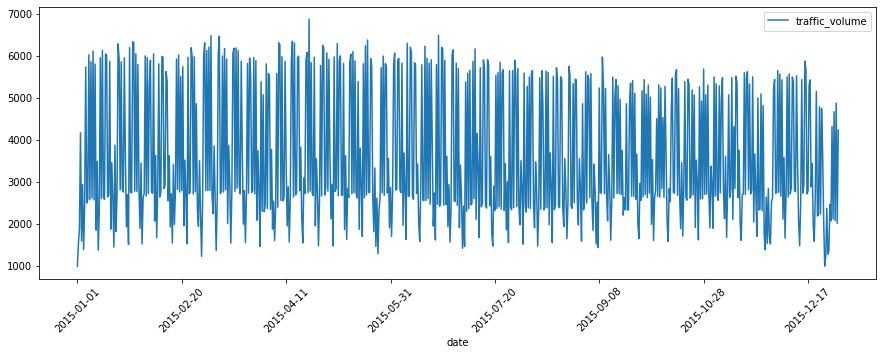

In [9]:
df_orig.plot(x="date",y="traffic_volume", rot=45, figsize=(15,5))

In [10]:
df = df_orig.iloc[:, 2:]
first_column = df.pop('traffic_volume')
df.insert(0, 'traffic_volume', first_column)
df.head()

,traffic_volume,day_of_data,day_of_week,direction_of_travel,month_of_data,precip,windgust,windspeed,cloudcover,visibility,conditions,holiday
210,986.0,1,5,3,1,0.0,22.0,10.0,9.7,9.9,0,1
584,1526.0,1,5,7,1,0.0,22.0,10.0,9.7,9.9,0,1
340,1898.0,2,6,3,1,0.0,22.0,10.9,11.9,9.9,0,0
681,4168.0,2,6,7,1,0.0,22.0,10.9,11.9,9.9,0,0
244,1586.0,3,7,3,1,0.0,22.0,10.9,20.0,9.9,0,0


In [11]:
values = df.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
pd.DataFrame(scaled).head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000000,0.000000,0.666667,0.0,0.0,0.0,0.233202,0.227979,0.097097,1.0,0.0,1.0
1,0.091681,0.000000,0.666667,1.0,0.0,0.0,0.233202,0.227979,0.097097,1.0,0.0,1.0
2,0.154839,0.033333,0.833333,0.0,0.0,0.0,0.233202,0.274611,0.119119,1.0,0.0,0.0
3,0.540238,0.033333,0.833333,1.0,0.0,0.0,0.233202,0.274611,0.119119,1.0,0.0,0.0
4,0.101868,0.066667,1.000000,0.0,0.0,0.0,0.233202,0.274611,0.200200,1.0,0.0,0.0


In [12]:
reframed = prepare_dataset(scaled, 1, 1)
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t)
1,0.000000,0.000000,0.666667,0.0,0.0,0.0,0.233202,0.227979,0.097097,1.000000,...,0.666667,1.0,0.0,0.0,0.233202,0.227979,0.097097,1.000000,0.0,1.0
2,0.091681,0.000000,0.666667,1.0,0.0,0.0,0.233202,0.227979,0.097097,1.000000,...,0.833333,0.0,0.0,0.0,0.233202,0.274611,0.119119,1.000000,0.0,0.0
3,0.154839,0.033333,0.833333,0.0,0.0,0.0,0.233202,0.274611,0.119119,1.000000,...,0.833333,1.0,0.0,0.0,0.233202,0.274611,0.119119,1.000000,0.0,0.0
4,0.540238,0.033333,0.833333,1.0,0.0,0.0,0.233202,0.274611,0.119119,1.000000,...,1.000000,0.0,0.0,0.0,0.233202,0.274611,0.200200,1.000000,0.0,0.0
5,0.101868,0.066667,1.000000,0.0,0.0,0.0,0.233202,0.274611,0.200200,1.000000,...,1.000000,1.0,0.0,0.0,0.233202,0.274611,0.200200,1.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,0.191511,0.933333,0.333333,0.0,1.0,0.0,0.233202,0.113990,0.092092,0.984127,...,0.333333,1.0,1.0,0.0,0.233202,0.113990,0.092092,0.984127,0.0,0.0
726,0.625467,0.933333,0.333333,1.0,1.0,0.0,0.233202,0.113990,0.092092,0.984127,...,0.500000,0.0,1.0,0.0,0.233202,0.186529,0.176176,0.984127,0.0,0.0
727,0.185059,0.966667,0.500000,0.0,1.0,0.0,0.233202,0.186529,0.176176,0.984127,...,0.500000,1.0,1.0,0.0,0.233202,0.186529,0.176176,0.984127,0.0,0.0
728,0.660611,0.966667,0.500000,1.0,1.0,0.0,0.233202,0.186529,0.176176,0.984127,...,0.666667,0.0,1.0,0.0,0.549407,0.264249,0.347347,1.000000,0.2,0.0


In [13]:
trainX, trainy, testX, testy = tt_split(reframed)
print(trainX.shape, trainy.shape, testX.shape, testy.shape)

(583, 1, 12) (583,) (146, 1, 12) (146,)


In [14]:
model = Sequential()
model.add(LSTM(10, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(10))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 10)             920       
                                                                 
 dropout (Dropout)           (None, 1, 10)             0         
                                                                 
 lstm_1 (LSTM)               (None, 10)                840       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 1,771
Trainable params: 1,771
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(trainX, trainy, epochs=50, batch_size=8, validation_split=0.25, verbose=0, shuffle=False) 

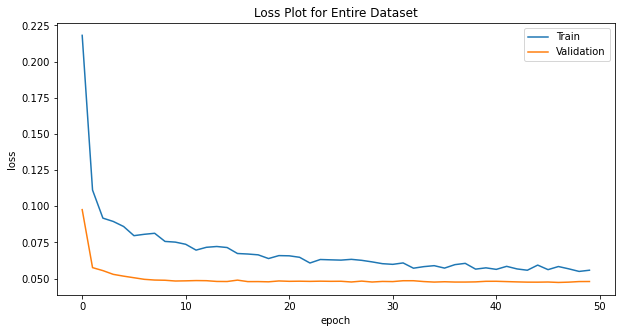

In [16]:
loss_plot(history, 'Entire Dataset')

The mean absolute error for Entire Dataset is 985.81934
The mean squared error for Entire Dataset is 1650362.8
The root mean squared error for Entire Dataset is 1284.6644
The r2 score for Entire Dataset is 0.18122883789243494
The adjusted r2 score for Entire Dataset is 0.10735474807821854
The root mean squared log error for Entire Dataset is 0.39585587


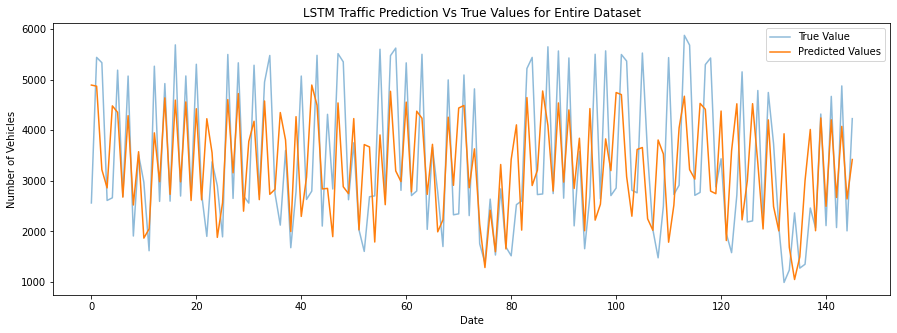

In [17]:
predictions(testX, testy, scaler, 'Entire Dataset')

In [18]:
df3 = df_orig[df.direction_of_travel == 3]
df7 = df_orig[df.direction_of_travel == 7]

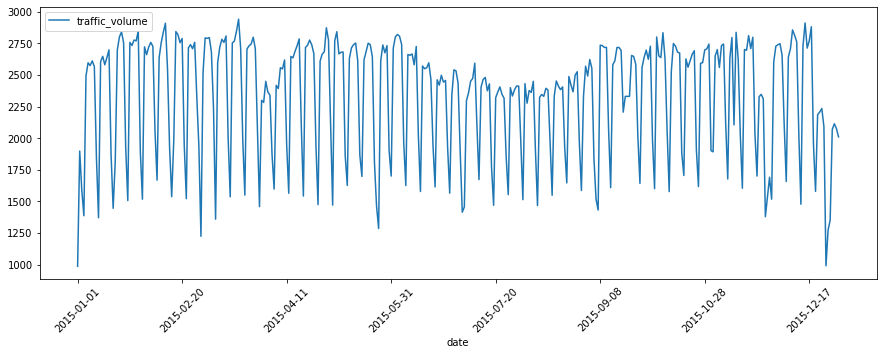

In [19]:
df3.plot(x="date",y="traffic_volume", rot=45, figsize=(15,5))

In [20]:
df3 = df3.iloc[:, 2:]
first_column = df3.pop('traffic_volume')
df3.insert(0, 'traffic_volume', first_column)
df3.head()

,traffic_volume,day_of_data,day_of_week,direction_of_travel,month_of_data,precip,windgust,windspeed,cloudcover,visibility,conditions,holiday
210,986.0,1,5,3,1,0.00,22.0,10.0,9.7,9.9,0,1
340,1898.0,2,6,3,1,0.00,22.0,10.9,11.9,9.9,0,0
244,1586.0,3,7,3,1,0.00,22.0,10.9,20.0,9.9,0,0
158,1386.0,4,1,3,1,0.00,22.0,11.4,34.8,8.5,1,0
9,2492.0,5,2,3,1,0.01,34.4,7.9,29.9,9.4,2,0


In [21]:
values = df3.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
pd.DataFrame(scaled).head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000000,0.000000,0.666667,0.0,0.0,0.000000,0.233202,0.227979,0.097097,1.000000,0.0,1.0
1,0.466258,0.033333,0.833333,0.0,0.0,0.000000,0.233202,0.274611,0.119119,1.000000,0.0,0.0
2,0.306748,0.066667,1.000000,0.0,0.0,0.000000,0.233202,0.274611,0.200200,1.000000,0.0,0.0
3,0.204499,0.100000,0.000000,0.0,0.0,0.000000,0.233202,0.300518,0.348348,0.777778,0.2,0.0
4,0.769939,0.133333,0.166667,0.0,0.0,0.007752,0.723320,0.119171,0.299299,0.920635,0.4,0.0


In [22]:
reframed = prepare_dataset(scaled, 1, 1)
trainX, trainy, testX, testy = tt_split(reframed)
print(trainX.shape, trainy.shape, testX.shape, testy.shape)

(291, 1, 12) (291,) (73, 1, 12) (73,)


In [23]:
model = Sequential()
model.add(LSTM(10, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(10))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 10)             920       
                                                                 
 dropout_2 (Dropout)         (None, 1, 10)             0         
                                                                 
 lstm_3 (LSTM)               (None, 10)                840       
                                                                 
 dropout_3 (Dropout)         (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,771
Trainable params: 1,771
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = model.fit(trainX, trainy, epochs=50, batch_size=8, validation_split=0.25, verbose=0, shuffle=False) 

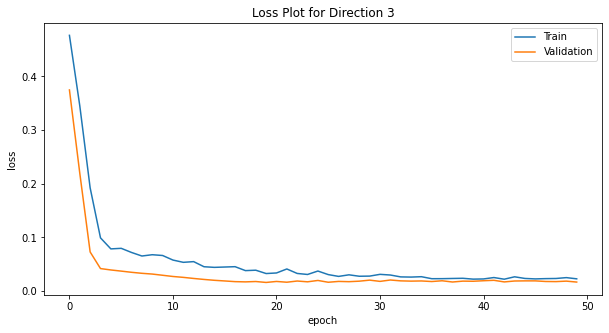

In [25]:
loss_plot(history, 'Direction 3')

The mean absolute error for Direction 3 is 239.29329
The mean squared error for Direction 3 is 96696.766
The root mean squared error for Direction 3 is 310.96103
The r2 score for Direction 3 is 0.594562308296958
The adjusted r2 score for Direction 3 is 0.5134747699563496
The root mean squared log error for Direction 3 is 0.14889564


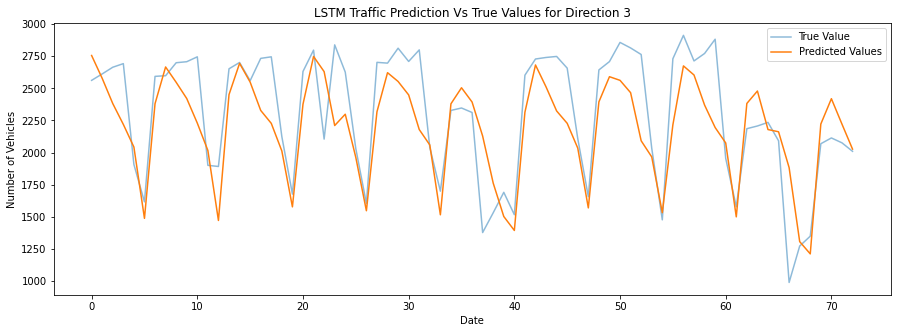

In [26]:
predictions(testX, testy, scaler, 'Direction 3')

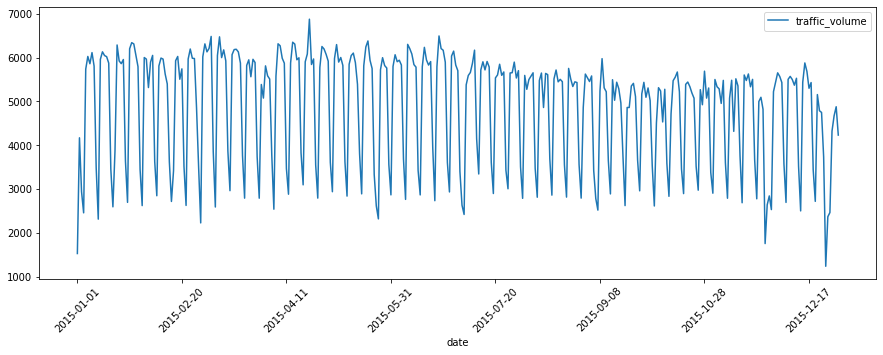

In [27]:
df7.plot(x="date",y="traffic_volume", rot=45, figsize=(15,5))

In [28]:
df7 = df7.iloc[:, 2:]
first_column = df7.pop('traffic_volume')
df7.insert(0, 'traffic_volume', first_column)
df7.head()

,traffic_volume,day_of_data,day_of_week,direction_of_travel,month_of_data,precip,windgust,windspeed,cloudcover,visibility,conditions,holiday
584,1526.0,1,5,7,1,0.00,22.0,10.0,9.7,9.9,0,1
681,4168.0,2,6,7,1,0.00,22.0,10.9,11.9,9.9,0,0
641,2936.0,3,7,7,1,0.00,22.0,10.9,20.0,9.9,0,0
397,2455.0,4,1,7,1,0.00,22.0,11.4,34.8,8.5,1,0
526,5736.0,5,2,7,1,0.01,34.4,7.9,29.9,9.4,2,0


In [29]:
values = df3.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
pd.DataFrame(scaled).head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000000,0.000000,0.666667,0.0,0.0,0.000000,0.233202,0.227979,0.097097,1.000000,0.0,1.0
1,0.466258,0.033333,0.833333,0.0,0.0,0.000000,0.233202,0.274611,0.119119,1.000000,0.0,0.0
2,0.306748,0.066667,1.000000,0.0,0.0,0.000000,0.233202,0.274611,0.200200,1.000000,0.0,0.0
3,0.204499,0.100000,0.000000,0.0,0.0,0.000000,0.233202,0.300518,0.348348,0.777778,0.2,0.0
4,0.769939,0.133333,0.166667,0.0,0.0,0.007752,0.723320,0.119171,0.299299,0.920635,0.4,0.0


In [30]:
reframed = prepare_dataset(scaled, 1, 1)
trainX, trainy, testX, testy = tt_split(reframed)
print(trainX.shape, trainy.shape, testX.shape, testy.shape)

(291, 1, 12) (291,) (73, 1, 12) (73,)


In [31]:
model = Sequential()
model.add(LSTM(10, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(10))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1, 10)             920       
                                                                 
 dropout_4 (Dropout)         (None, 1, 10)             0         
                                                                 
 lstm_5 (LSTM)               (None, 10)                840       
                                                                 
 dropout_5 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,771
Trainable params: 1,771
Non-trainable params: 0
_________________________________________________________________


In [32]:
history = model.fit(trainX, trainy, epochs=50, batch_size=8, validation_split=0.25, verbose=0, shuffle=False)

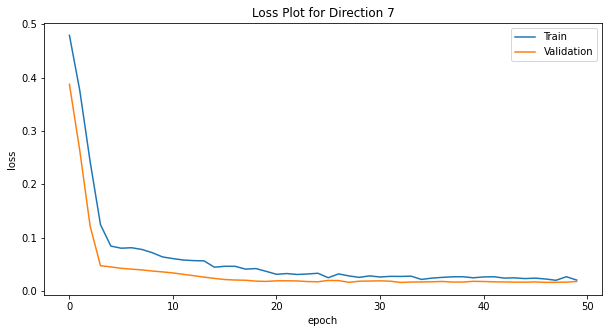

In [33]:
loss_plot(history, 'Direction 7')

The mean absolute error for Direction 7 is 238.29137
The mean squared error for Direction 7 is 98170.36
The root mean squared error for Direction 7 is 313.3215
The r2 score for Direction 7 is 0.5883836813062294
The adjusted r2 score for Direction 7 is 0.5060604175674753
The root mean squared log error for Direction 7 is 0.1478706


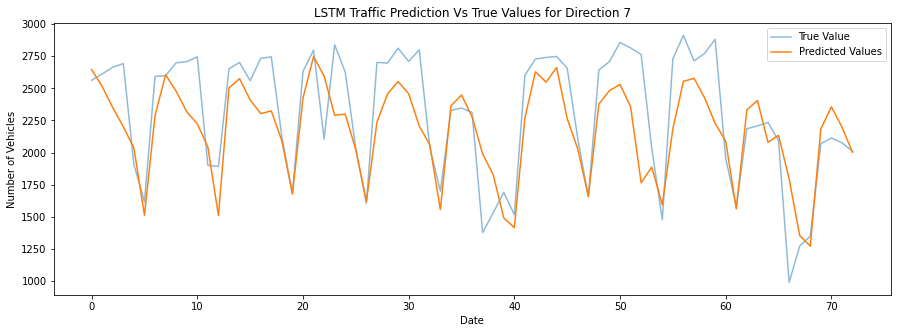

In [34]:
predictions(testX, testy, scaler, 'Direction 7')

In [35]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var1(t)
1,0.000000,0.000000,0.666667,0.0,0.0,0.000000,0.233202,0.227979,0.097097,1.000000,0.0,1.0,0.466258
2,0.466258,0.033333,0.833333,0.0,0.0,0.000000,0.233202,0.274611,0.119119,1.000000,0.0,0.0,0.306748
3,0.306748,0.066667,1.000000,0.0,0.0,0.000000,0.233202,0.274611,0.200200,1.000000,0.0,0.0,0.204499
4,0.204499,0.100000,0.000000,0.0,0.0,0.000000,0.233202,0.300518,0.348348,0.777778,0.2,0.0,0.769939
5,0.769939,0.133333,0.166667,0.0,0.0,0.007752,0.723320,0.119171,0.299299,0.920635,0.4,0.0,0.823620
...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,0.146728,0.833333,1.000000,0.0,1.0,0.000000,0.407115,0.523316,0.000000,1.000000,0.0,0.0,0.186094
361,0.186094,0.866667,0.000000,0.0,1.0,0.000000,0.233202,0.233161,0.439439,1.000000,0.2,0.0,0.553681
362,0.553681,0.900000,0.166667,0.0,1.0,0.116279,0.205534,0.145078,0.819820,0.936508,0.4,0.0,0.576687
363,0.576687,0.933333,0.333333,0.0,1.0,0.000000,0.233202,0.113990,0.092092,0.984127,0.0,0.0,0.557260
